# Le Teil earthquake epicenter location likelihood

<img src="images/logo-epos.png" style="margin:10px; height:80px;"/><img src="images/logo-esa.png" style="margin:10px; height:100px;"/><img src="images/logo-ipgp-upc.png" style="margin:10px; height:80px;"/>

The original version of this notebook was made by Antoine Lucas and Gregory Sainton. The current notebook was edited in 2023 by Leonard Seydoux (seydoux@ipgp.fr) to be used in the course _Earth Data Science_ at the [Institut de Physique du Globe de Paris](https://www.ipgp.fr/fr) (IPGP). If you have found a bug or have a suggestion, please feel free to contact me.

## 1. Introduction

On November 11, 2019, a Mw 4.9 earthquake occured in the south of France, near the city of Le Teil. In this notebook, we will use the seismic data recorded by the RESIF network to estimate the epicenter location by a simple Monte Carlo method.

This notebook is based on the example of _estimation of an epicenter: direct use of the probabilistic method_ made by Albert Tarantola, from the book _Inverse Problem Theory and Methods for Model Parameter Estimation_ (SIAM, 2005), pp. 253-256. We will use seven stations from the [French part of the European Plate Observing System (EPOS)](https://www.epos-france.fr/) and explore some parameters of the problem. We will also use the InSAR data from the Sentinel-1 satellite a a prior information to constrain the epicenter location. The production of the InSAR displacement map (available in the `data` repository) was made by Antoine Lucas using SNAP.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import obspy
from obspy.clients.fdsn import Client
import rasterio
from rasterio.plot import show

import solver

## 1. Introduction

### 1.1. Inverse problem theory

Introducing to the topic of probabilistic methods, Albert Tarantola wrote in his book [Inverse Problem Theory](https://www.ipgp.fr/~tarantola/Files/Professional/Books/InverseProblemTheory.pdf), edited by Siam in 2005 (slightly modifified from p.20).

Experiments suggest physical theories, and physical theories predict the outcome of experiments. The comparision of the predicted outcome with the observed outcome allows us to improve the theory. If in the _physical theory_ we include the physical parameters describing the system under study, then inverse problem theory is about the quantitative rules to be used for this comparison between predictions and observations.

To solve a _forward problem_ means to predict the error-free values of the observables $\mathbf{d} = (d_1, d_2, \ldots)$ that would correspond to a given model $\mathbf{m} = (m_1, m_2, \dots)$. It can be formally written in the form

$$\mathbf{m} \mapsto \mathbf{d} = \mathbf{g}(\mathbf{m}),$$

where $\mathbf{d} = \mathbf{g}(\mathbf{m})$ is a short notation for the set of equations $d_i = g_i(\mathbf{m})$, and $\mathbf{g}$ is the _forward operator_ that contains the mathematical model of the physical system under study. It is usually a nonlinear operator, and it is often ill-posed. 

### 1.2. Earthquake epicenter location problem

In the problem of earthaquake epicenter likelihood estimation, the goal is to find the geographical coordinates 
$\lambda$ and $\varphi$ (respectively the latitude and the longitude) of the epicenter that best match the observations. Following the notations of Albert Tarantola, we will name $\lambda$ and $\varphi$ the two parameters of the model space $\mathbb M$, and assemble them into a vector 

$$\mathbf{m} = (\lambda, \varphi) \in \mathbb{M} = [-90, 90] \times [-180, 180],$$

with all angles expressed in decimal degrees. On the observation side, we have several choices we can make depending on the physical model at hand. A simple model predicts the travel time $t_i$ of the seismic waves at the $i$-th seismic station, so the generic data vector $\bf d$ can be written as

$$\mathbf{d} = (t_1, \ldots, t_N) \in \mathbb{R}^N.$$

In the following, we distinguish the actual observations $\mathbf{d}$ from the predictions $\hat{\bf d}$ made by the model. Note that the arrival times can be noisy due to several reasons (the noise in the data, picking accuracy). If the speed of the seismic waves in the medium between the source and the sensors is known, it is possible to predict, thanks to a given physical model, the arrival times of the seismic waves $\hat{\mathbf{d}}$ at the stations for a given epicenter location. In other terms, we can then apply the forward problem

$$\hat{\mathbf{d}} = \mathbf{g}(\mathbf{m}).$$

In the present case, the forward operators $g_i$ is the travel time model that predicts the travel times $t_i$ for a given epicenter location $m$ at the seismic sensor located at position $(\lambda_i, \varphi_i)$, and it is based on the knowledge of the velocity model of the medium. In this notebook, we will use a simple velocity model that does not depend on space, that is, the forward operator is linear and only depends on the distance between the epicenter and the station. 

> __Question 1.__ Give the form of the forward operator $g_i$ for a linear velocity model, noting $v$ the space-independent velocity of the _P_ wave in the medium. What are the assumptions made in this model?
> 
> __Answer 1.__ The coordinates of the seismic stations and the velocity of the _P_ wave are assumed which means that the velocities uncertainties are supposed to be negligible in comparison with the uncertainties of the observed arrival times. For a source located at the position $\mathbf{m} = (\lambda, \varphi)$, the predicted arrival times $\hat{t}_i$ of the seismic wave recorded at station $i$ located at $(\lambda_i, \varphi_i)$ are predicted by the forward model $g_i$ as
> 
> $$ \hat{t}_i = g_i(\lambda, \varphi) = \frac{1}{v}\delta(\lambda, \varphi, \lambda_i, \varphi_i),$$
>
> where $\delta$ is the great-circle distance between the source and the station.

### 1.3. Probabilistic inversion

From the lecture, we know that the _posterior_ information $\sigma(\mathbf{m})$ is a combination of all informations we have which can be expressed as 

$$\sigma(\mathbf{m}) = k \rho(\mathbf{m}) L(\mathbf{m})$$

where $k$ is a normalization constant, $\rho(\mathbf{m})$ is the _a priori_ in the model space, and $L(\mathbf{m})$ is the likelihood function which gives a measure of the agreement between the observed data and the predicted data, in other terms, on how good the model $\mathbf{m}$ fits the data $\mathbf{d}$. If we consider the uncertainties to be Gaussian with a standard deviation $\nu$, the likelihood function $L(\mathbf{m})$ is expressed as:

$$L(\mathbf{m}) = k' \exp\left( -\frac{1}{2} \sum\limits_{i=1}^{n} \left(\frac{t_{i}-g_i(\mathbf{m})}{\nu}\right)^2 \right)$$

where $k'$ is a normalization constant. Injecting the likelihood function into the posterior information, we obtain

$$
\sigma(\mathbf{m}) = kk' \rho(\mathbf{m}) \exp\left( -\frac{1}{2} \sum_{i=1}^{n} \left(\frac{t_{i}-g_i(\mathbf{m})}{\nu}\right)^2\right)
$$

For now, we can take the a priori information $\rho(\mathbf{m})$ as a constant, since we do not have yet a priori information about the epicenter location. We will come back to this point later. The posterior information $\sigma(\mathbf{m})$ is then proportional to the likelihood function $L(\mathbf{m})$, which means that the maximum of the posterior information is also the maximum of the likelihood function. We can then maximize the likelihood function to find the epicenter location, denoted $m^*$, that best fits the data. The maximum of the likelihood function is obtained by maximizing the following function:

$$
\mathbf{m}^* = (\lambda^*, \varphi^*) = \arg\max\limits_{\mathbf{m}}\, \exp\left(-\frac{1}{2} \sum\limits_{i=1}^{n} \left(\frac{t_{i}-g_i(\mathbf{m})}{\nu}\right)^2\right).
$$

> __Question 2.__ What is the difference between the maximum of the posterior information and the maximum of the likelihood function? How would the expression of the posterior information change if we had a priori information about the epicenter location?
> 
> __Answer 2.__ The maximum of the posterior information is the maximum of the likelihood function multiplied by the a priori information. If we had a priori information about the epicenter location, we would have to multiply the likelihood function by the a priori information, which would change the expression of the posterior information.

## 2. Reading and preparing the data

### 2.1. Get event information from EPOS-France

Of course when inferring an earthquake epicenter, you often have a bare idea of the event's location and time (human reports, timing of the first arrivals, etc.). Here we use the exact information provided by the BRGM (Bureau de Recherches Géologiques et Minières) that is available on the [website of EPOS-France](https://www.epos-france.fr/blog/2021/01/19/reponse-rapide-de-la-communaute-resif-au-tremblement-de-terre-mw-4-9-du-11-novembre-2019-au-teil/). We will then fetch the event information from the EPOS-France web service using the `obspy` package. 

Note that the data from EPOS-France is still available via the `RESIF` entry within `obspy`, as it was renamed to EPOS-France in 2022. 

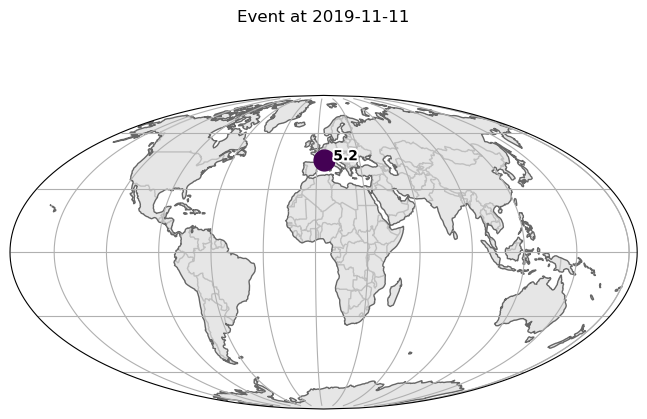

In [3]:
# Connect to the RESIF web service
client = Client("RESIF")

# Get a list of events around the time of the earthquake
catalog = client.get_events(
    starttime=obspy.UTCDateTime(2019, 11, 11, 10, 50),
    endtime=obspy.UTCDateTime(2019, 11, 11, 10, 55),
)

# Plot the events on a map
catalog.plot()
plt.show()

### 2.2 Fetch available stations

We can now look for available seismic station around the time and place of the estimated earthaquake location. Note that with the seismic network in France, we have a good coverage of the country and may find already about 10 seismic station with a distance of less than 100km from the epicenter. We will use the `obspy` package to fetch the available stations.

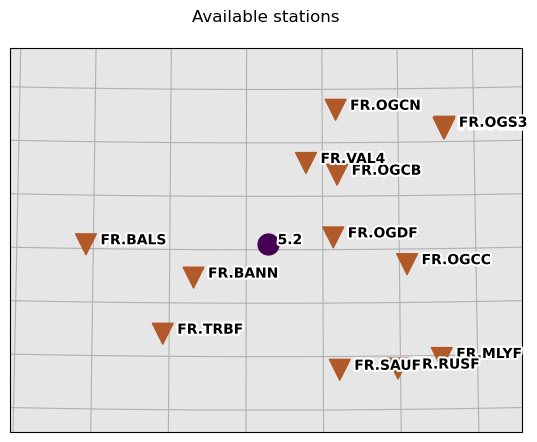

In [4]:
# Get the only event in the catalog
event = catalog[0]

# Look for station near the epicenter
inventory = client.get_stations(
    network="FR",
    channel="HHZ",
    starttime=event.origins[0].time,
    endtime=event.origins[0].time + 125,
    latitude=event.origins[0].latitude,
    longitude=event.origins[0].longitude,
    maxradius=1,
    matchtimeseries=True,
    level="response"
)

# Plot inventory
fig = inventory.plot(projection="local", resolution="i", show=False)
catalog.plot(projection="local", resolution="i", fig=fig, title="Available stations")
plt.show()

### 2.3. Download waveforms

The next cell show you how to download the waveform data from the RESIF datacenter. Note that we also provide the waveform data in the `data` repository, so you can skip this step if you want to save some time. In order to turn on the download, you have to set the variable `REDOWNLOAD` to `True`. You should also take the time to carefully read this cell and understand what is done therein. The output of the download is an `obpsy.Stream` object that contains the seismic records (one `obspy.Trace` object per station). Take the time to read the documentation of the `obspy` package to understand how to use the `Stream` and `Trace` objects.

> __Question 3.__ Looking a the documentation of the `obspy.get_waveforms` function, what are the meaning of the network and station codes? What about the channel? Why bother mergin the traces before aggregating them in a `Stream` object?
> 
> __Answer 3.__ The network code is a two-letter code that identifies the network. The station code is a three-letter code that identifies the station. The channel code is a three-letter code that identifies the channel. The channel code is composed of three letters: the first letter is the location code, the second letter is the channel code, and the third letter is the orientation code. The location code is used to distinguish between multiple sensors at the same station. The channel code is used to distinguish between different types of data from the same sensor. The orientation code is used to distinguish between different orientations of the same type of data from the same sensor. The traces are merged before aggregating them in a `Stream` object because the `Stream` object is a collection of traces that are processed together. The traces are merged to avoid having multiple traces for the same station.

In [5]:
REDOWNLOAD = True

if REDOWNLOAD is True:

    # Create an empty stream object
    stream = obspy.Stream()

    # Loop every network and station
    for network in inventory:
        for station in network:

            try:

                # Get waveform data
                trace = client.get_waveforms(
                    network.code,
                    station.code,
                    "*",
                    "HHZ",
                    starttime=event.origins[0].time,
                    endtime=event.origins[0].time + 125,
                )

                # Merge data
                trace.merge(fill_value="interpolate")

                # Keep only one trace if several returned
                trace = trace[0]

                # Add station location
                trace.stats.coordinates = {
                    "latitude": station.latitude,
                    "longitude": station.longitude,
                }

                # Add distance from epicenter
                trace.stats.distance = obspy.geodetics.locations2degrees(
                    event.origins[0].latitude,
                    event.origins[0].longitude,
                    trace.stats.coordinates["latitude"],
                    trace.stats.coordinates["longitude"],
                )

                # Add to stream
                stream += trace

            except:

                # If no data, print a message and continue
                print(f"No data found for station {network.code}.{station.code}")

    # Save stream as pickle file to keep the coordinates (not possible with miniseed)
    stream.write("data/waveforms.pickle", format="PICKLE")

    # Print success message
    print(f"Saved {len(stream)} traces in ./data/waveforms.pickle")

else:
    
    # Load stream from pickle file
    stream = obspy.read("data/waveforms.pickle")

    # Print success message
    print(f"Loaded {len(stream)} traces from ./data/waveforms.pickle")


No data found for station FR.OGS1
No data found for station FR.TRBF
No data found for station FR.VAL4
Saved 11 traces in ./data/waveforms.pickle


### 2.4. Print basic waveform information

In `obspy`, a `Trace` object contains the waveform data and the metadata associated with the waveform. The metadata is stored in the `stats` attribute of the `Trace` object, which is a dictionary-like object with human-readable keys. Access one trace of the `Stream` object and print the metadata associated with it. 

> __Question 4.__ What is the sampling rate of this trace? What is the start time and end time, and how many points do we have in this trace? Do every traces have the same sampling rate and number of points?
> 
> __Answer 4.__ Most of traces have a sampling rate of 100 Hz, but some traces have a sampling rate of 200 Hz. The start time is 2019-11-11T10:52:40 and the end time 2019-11-11T10:54:50. We note that the start and end time are not exactly the same for all traces (sample precision). The number of points changes from one trace to another, but most of traces have 13000 points.

In [6]:
# Use the same idea to check every entry of the stats object
[trace.stats.endtime for trace in stream]

[2019-11-11T10:54:50.840000Z,
 2019-11-11T10:54:50.840000Z,
 2019-11-11T10:54:50.830500Z,
 2019-11-11T10:54:50.840000Z,
 2019-11-11T10:54:50.840000Z,
 2019-11-11T10:54:50.840000Z,
 2019-11-11T10:54:50.840000Z,
 2019-11-11T10:54:50.840000Z,
 2019-11-11T10:54:50.840000Z,
 2019-11-11T10:54:50.830660Z,
 2019-11-11T10:54:50.840000Z]

> __Question 5.__ Plot the various seismic waveforms and give a basic description of what you observe. using the `plot` method of a `Stream` object, plot them as a function of the epicentral distance to the earthquake. What is the sampling rate of the seismic records? What is the unit of the waveform amplitudes? Check the documentation of the `obspy` package to find the answer if needed. 
>
> __Answer 5.__ We check the properties of the seismic records using the `stats` attribute of the `Trace` object, obtained from the elements of the `Stream` object. See the ouput of the cell below. The amplitude of the waveforms is in counts.

[100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 200.0, 200.0, 100.0, 100.0]


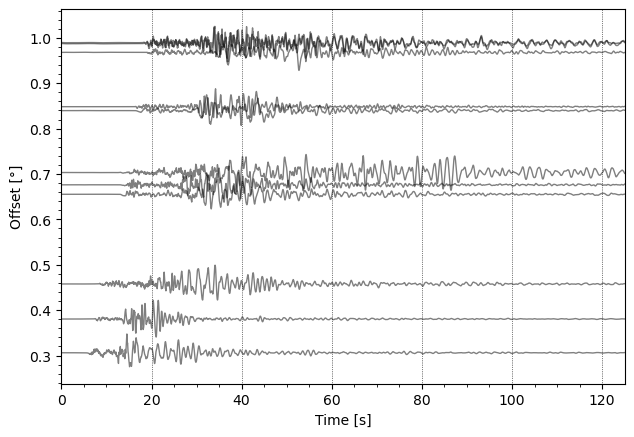

In [7]:
# Prepare figure
fig = plt.figure()

# Plot the stream
stream.plot(
    type="section",
    orientation="horizontal",
    dist_degree=True,
    ev_coord=(event.origins[0].latitude, event.origins[0].longitude),
    show=False, 
    fig=fig,
)

# Sampling frequency
print([trace.stats.sampling_rate for trace in stream])


### 2.5. Plot waveforms and pick the P-wave arrival times

Now we can explore the data content and pick the P-wave arrival times. Picking seismic arrival times is a difficult task that requires a lot of experience. Usually, this is done by a human expert. Here we will use the `obspy` package to pick the P-wave arrival times, using a old-school method based on the STA/LTA ratio (short-time average over long-term average). We will use the `obspy` package to plot the seismic records and the picked arrival times.

> __Question 6.__ The STA/LTA method is a simple method to pick the P-wave arrival times. What are the advantages and disadvantages of this method? What values of the STA/LTA ratio would you use to pick the P-wave arrival times?
> 
> __Answer 6.__ The STA/LTA method is a simple method to pick the P-wave arrival times. It is based on the fact that the P-wave arrival times are characterized by a high-frequency content, which is not the case for the noise. The STA/LTA method is based on the ratio of the short-term average (STA) and the long-term average (LTA) of the seismic records. The STA/LTA ratio is high for the P-wave arrival times and low for the noise. The STA/LTA method is simple to implement and can be automated. However, it is not robust to the presence of high-frequency noise in the seismic records. We will use a STA of 3 and a LTA of 8 to pick the P-wave arrival times, after some trial and error. We note that this value is not optimal for all the stations (such as OSG2).

No onset found for FR.OGS2.00.HHZ


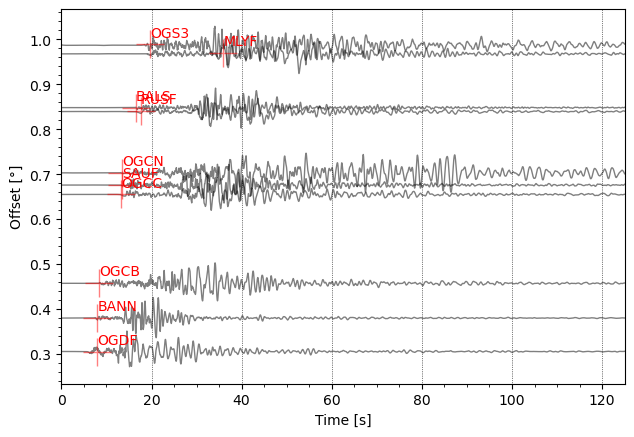

In [8]:
from obspy.signal.trigger import classic_sta_lta, trigger_onset

# Define the short and long term average
short_term_average = 3
long_term_average = 8

# Get firt arrive time
for trace in stream:
    # Convert short and long term average to number of samples
    n_sta = int(short_term_average * trace.stats.sampling_rate)
    n_lta = int(long_term_average * trace.stats.sampling_rate)

    # Get trigger
    trigger = classic_sta_lta(trace.data, n_sta, n_lta)

    # Get onset from trigger function
    onset = trigger_onset(trigger, 2, 0.5)

    # If onset is found, add it to the trace
    if np.size(onset) > 0:
        onset = onset[0, 0]
        trace.stats.onset = onset / trace.stats.sampling_rate
    else:
        # Print a message if no onset is found
        stream.remove(trace)
        print(f"No onset found for {trace.id}")

# Prepare figure
fig = plt.figure()

# Plot the stream
stream.plot(
    type="section",
    orientation="horizontal",
    dist_degree=True,
    ev_coord=(event.origins[0].latitude, event.origins[0].longitude),
    show=False, 
    fig=fig,
)

# Plot the onset
for trace in stream:
    plt.plot(trace.stats.onset, trace.stats.distance, "r+", mfc="none", ms=20, alpha=0.5)
    plt.text(trace.stats.onset, 0.01 + trace.stats.distance, trace.stats.station, va="bottom", color="r")

## 3. Estimation of the epicenter location without a priori information

### 3.1. Epicenter likelihood from a few stations

At first we will work with (deliberately) too few seismic stations which naturally brings biases in the estimation of the epicenter location. We will select three stations located in a line along the Rhône valley: OGCN, OGCB, and OGDF. The cell below allows you to select the traces from these three stations.

In [9]:
# Extract selected traces
stream_line = obspy.Stream()
for station in ("OGCN", "OGCB", "OGDF"):
    stream_line += stream.select(station=station)
    
# Print stream information
print(stream_line)

3 Trace(s) in Stream:
FR.OGCN.00.HHZ | 2019-11-11T10:52:45.850000Z - 2019-11-11T10:54:50.840000Z | 100.0 Hz, 12500 samples
FR.OGCB.00.HHZ | 2019-11-11T10:52:45.850000Z - 2019-11-11T10:54:50.840000Z | 100.0 Hz, 12500 samples
FR.OGDF.00.HHZ | 2019-11-11T10:52:45.850000Z - 2019-11-11T10:54:50.840000Z | 100.0 Hz, 12500 samples


Now the idea is to sample the probability density $L(\mathbf{m})$ at random potential positions $\{\mathbf{m}_i\}_{i=1\dots K}$ to have an idea of the entire probability distribution.

> __Question 7.__ Explore the module `solver.py` and find a way to estimate the epicenter location from a set of randomly sampled positions. Look for the likelihood within an extent of longitudes between 3º and 7º, and latitudes between 43º and 46º. What uncertainty about the picking should you take into account? How many random positions should you sample to get a good estimate of the epicenter location? What value should you take for the wave velocity? What is the epicenter location you obtain? What is the posterior uncertainty on the epicenter location?
> 
> __Answer 7.__ We use the `solver.py` module to estimate the epicenter location from a set of randomly sampled positions. We take an uncertainty of 10 second about the picking. We sample 10000 random positions to get a good estimate of the epicenter location. We obtain an epicenter location of (4.4ºE, 44.5ºN) with a posterior uncertainty of 0.5º in longitude and 1.5º in latitude. Because of the geometry of the array, we also observe an ambiguity in the epicenter location (see the figure below). We will consider a wave velocity of 3.5 km/s.

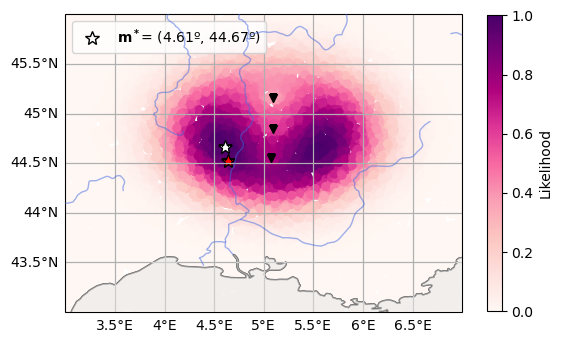

In [10]:
# Define the extent of the model
extent = [3, 7, 43, 46]

# Run the Monte Carlo simulation
latitudes, longitudes, likelihood = solver.monte_carlo_gaussian(
    stream_line, shots=10000, uncertainty=10, wavespeed=5, extent=extent
)

# Plot the likelihood
ax = solver.basemap(extent=extent, stream=stream_line, event=event)

# Plot likelihood
img = ax.scatter(longitudes, latitudes, c=likelihood, cmap="RdPu", s=30)
plt.colorbar(img, ax=ax, label="Likelihood", shrink=0.8)

# Plot the epicenter
index_max = np.argmax(likelihood)
label = rf"$\bf m^*$= ({longitudes[index_max]:.2f}º, {latitudes[index_max]:.2f}º)"
plt.plot(longitudes[index_max], latitudes[index_max], "k*", label=label, mfc="w", ms=10)
ax.legend(loc="upper left")

# Show
plt.show()

### 3.2. Epicenter likelihood from all stations

Now we will work with all the stations we have found in the previous step. 

> __Question 8.__ Using the same method than in the previous case, recalculate the likelihood function and plot it as a function of the epicenter location using all the available stations. What difference do you see with the previous case? What is the epicenter location that maximizes the likelihood function? What value of the wavespeed seems to be the best fit for the data?
> 
> __Answer 8.__ The epicenter location that maximizes the likelihood function is $(\lambda^*, \varphi^*) = (44.62, 4.66)$. The difference with the previous case is that the likelihood function is more peaked around the maximum, and closer to the ground truth. The value of the wavespeed that seems to be the best fit for the data is $v = 3.5$ km/s. We note that in the previous case, we also observe that there is a strong uncertainty in the location because of the symmetry of the likelihood function that is due to the linear shape of the seismic stations.

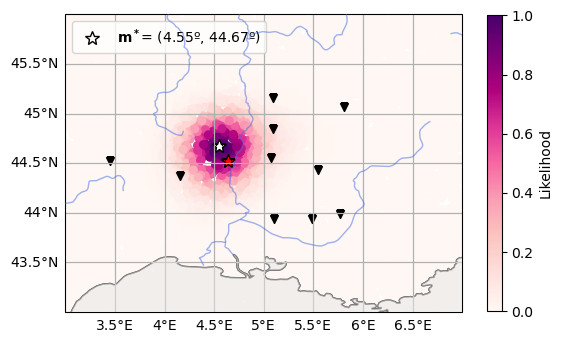

In [11]:
extent = [3, 7, 43, 46]

latitudes, longitudes, likelihood = solver.monte_carlo_gaussian(
    stream, shots=10000, uncertainty=10, wavespeed=5, extent=extent
)

# Plot the likelihood
ax = solver.basemap(extent=extent, stream=stream, event=event)

# Plot likelihood
img = ax.scatter(longitudes, latitudes, c=likelihood, cmap="RdPu", s=30)
plt.colorbar(img, ax=ax, label="Likelihood", shrink=0.8)

# Plot the epicenter
index_max = np.argmax(likelihood)
label = rf"$\bf m^*$= ({longitudes[index_max]:.2f}º, {latitudes[index_max]:.2f}º)"
plt.plot(longitudes[index_max], latitudes[index_max], "k*", label=label, mfc="w", ms=10)
ax.legend(loc="upper left")

# Show
plt.show()

### 3.3. Residuals analysis

Let's now look at the residuals between the observed and predicted arrival times for every stations in the best-fit case. 

> __Question 9.__ Using the functions located in the module `solver.py`, calculate the residuals between the observed and predicted arrival times for every stations in the best-fit case. Plot the residuals as a function of the stations. What do you observe? Which station has the largest residuals? What does it mean?
> 
> __Answer 9.__ We observe that the residuals are not zero for all stations. The station with the largest residuals is MLYF. This means that the model is not perfect and that we could improve it by taking into account the velocity model of the medium.

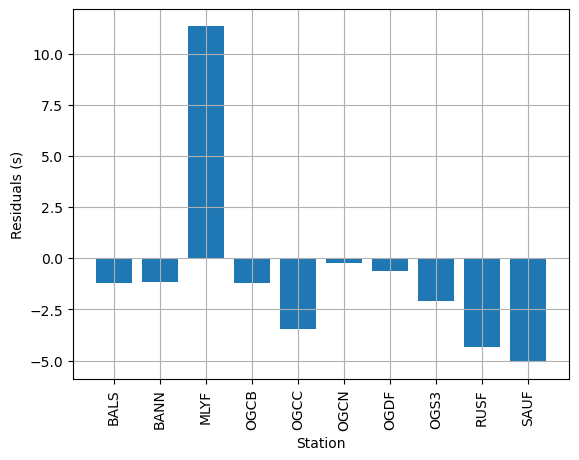

In [12]:
# Calcate residuals
t_observed = np.array([trace.stats.onset for trace in stream])
t_predicted = solver.predict_travel_times(
    stream, latitudes[index_max], longitudes[index_max], wavespeed=5
)
residuals_gaussian = t_observed - t_predicted

# Plot residuals
fig, ax = plt.subplots()

# Bar plot  with station names
ax.bar([trace.stats.station for trace in stream], residuals_gaussian)

# Labels
ax.tick_params(axis="x", rotation=90) 
ax.set_xlabel("Station")
ax.set_ylabel("Residuals (s)")
ax.grid()


### 3.4. Deal with biases in the dataset

One of the main issue of the Gaussian model is the strong sensitivy to outliers, because of the quadratic term in the exponent. You are now invited to consider changing the Gaussian model by the more robust Laplacian model, or introducing a priori information. Let's first start with the Laplacian model.

$$L(\mathbf{m}) = k' \exp\left( -\sum\limits_{i=1}^{n} \left|\frac{t_{i}-g_i(\mathbf{m})}{\nu}\right| \right)$$


where $k'$ is a normalization constant. For sake of simplicity of this lab, we can ignore it and turn it to 1.

> __Question 10.__ Modify the `solver.py` module to use the Laplacian model instead of the Gaussian model. Perform again the estimation of the epicenter location using all the available stations, and show the results in space. On a residual plot, compare the residuals obtained with the Gaussian and Laplacian models. What do you observe? What is the epicenter location that maximizes the likelihood function? What value of the wavespeed seems to be the best fit for the data?

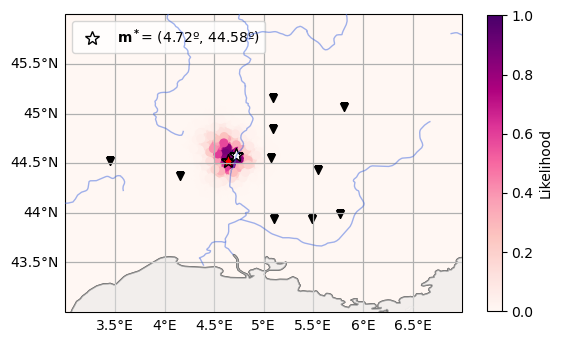

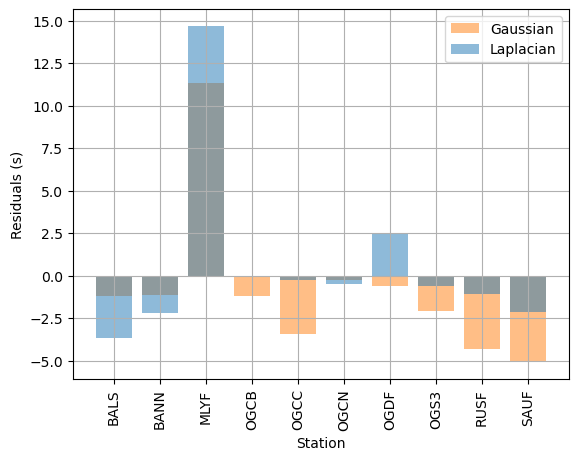

In [13]:
extent = [3, 7, 43, 46]

latitudes, longitudes, likelihood = solver.monte_carlo_laplacian(
    stream, shots=40000, uncertainty=6, wavespeed=5, extent=extent
)

# Plot the likelihood
ax = solver.basemap(extent=extent, stream=stream, event=event)

# Plot likelihood
img = ax.scatter(longitudes, latitudes, c=likelihood, cmap="RdPu", s=30)
plt.colorbar(img, ax=ax, label="Likelihood", shrink=0.8)

# Plot the epicenter
index_max = np.argmax(likelihood)
label = rf"$\bf m^*$= ({longitudes[index_max]:.2f}º, {latitudes[index_max]:.2f}º)"
plt.plot(longitudes[index_max], latitudes[index_max], "k*", label=label, mfc="w", ms=10)
ax.legend(loc="upper left")

# Show
plt.show()

# Calculate residuals
t_observed = np.array([trace.stats.onset for trace in stream])
t_predicted = solver.predict_travel_times(
    stream, latitudes[index_max], longitudes[index_max], wavespeed=5
)
residuals_laplacian = t_observed - t_predicted

# Plot residuals
fig, ax = plt.subplots()

# Bar plot  with station names
ax.bar([trace.stats.station for trace in stream], residuals_gaussian, color="C1", alpha=0.5, label="Gaussian")
ax.bar([trace.stats.station for trace in stream], residuals_laplacian, color="C0", alpha=0.5, label="Laplacian")

# Labels
ax.tick_params(axis="x", rotation=90) 
ax.set_xlabel("Station")
ax.set_ylabel("Residuals (s)")
ax.legend()
ax.grid()


## 4. Estimation of the epicenter location with a priori information

### 4.1. InSAR-derived prior information

Now, we will add a priori information from the postseismic surface displacement inferred from Sentinel-S1 InSAR between November 6 and November 12, 2019. The displacement map is available in the `data` repository. The displacement map is a GeoTiff file that contains the displacement in the vertical direction (in meters) between the two dates. The GeoTiff file contains the geographic coordinates of the corners of the image, and the resolution of the image. We will use the `rasterio` package to read the GeoTiff file and extract the displacement map. We will then use the `matplotlib` package to plot the displacement map.

> __Question 11.__ Using the InSAR-based displacement map, infer (manually) a prior information about the earthquake epicenter, and the uncertainty about the epicenter location. 
> 
> __Answer 11.__ We infer a prior information about the earthquake epicenter from the displacement map. We observe that the displacement map has a maximum line at the position $(\lambda, \varphi) = (44.52, 4.65)$. We also observe a lateral uncertainty of about 0.02º in longitude. 

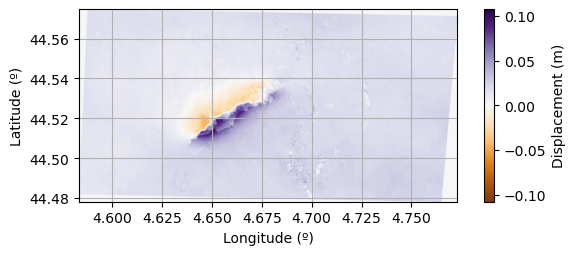

In [14]:
# Read displacement map
displacement = rasterio.open("data/displacement_06-11-2019_12-11-2019.tif")

# Metadata
absolute_max = np.abs(displacement.read().squeeze()).max()
insar_extent = displacement.bounds.left, displacement.bounds.right, displacement.bounds.bottom, displacement.bounds.top

# Show image
fig, ax = plt.subplots(figsize=(7, 2.5))
show(displacement, ax=ax, cmap="PuOr", vmin=-absolute_max, vmax=absolute_max)
mappable = ax.get_children()[0]
plt.colorbar(mappable, ax=ax, label="Displacement (m)")
ax.set_xlabel("Longitude (º)")
ax.set_ylabel("Latitude (º)")
ax.grid()
plt.show()

### 4.2. Estimation of the epicenter location with a priori information

We can now use this prior information to constrain the epicenter location. Consdiering a Gaussian prior information $\rho(\mathbf{m})$ centered on the InSAR epicenter location $(\lambda_0, \varphi_0)$ with a standard deviation $\sigma_0$, the prior information is expressed as

$$\rho(\mathbf{m}) = \frac{1}{2\pi\sigma_0^2} \exp\left(-\frac{1}{2}\frac{(\lambda-\lambda_0)^2 + (\varphi-\varphi_0)^2}{\sigma_0^2}\right).$$

> __Question 12.__ Write a function that calculates the posterior information $\sigma(\mathbf{m})$ from the likelihood function $L(\mathbf{m})$ and the prior information $\rho(\mathbf{m})$. Using the same method than in the previous case, recalculate the likelihood function and plot it as a function of the epicenter location using all the available stations. What difference do you see with the previous case? What is the epicenter location that maximizes the likelihood function? What value of the wavespeed seems to be the best fit for the data?
> 
> __Answer 12.__ The epicenter location that maximizes the likelihood function is $(\lambda^*, \varphi^*) = (44.52, 4.65)$. The difference with the previous case is that the likelihood function is more peaked around the maximum, and closer to the ground truth. The value of the wavespeed that seems to be the best fit for the data is $v = 3.5$ km/s. We note that in the previous case, we also observe that there is a strong uncertainty in the location because of the symmetry of the likelihood function that is due to the linear shape of the seismic stations.

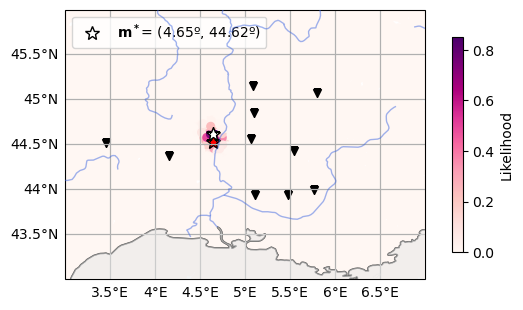

In [19]:
# Get likelihood
latitudes, longitudes, likelihood = solver.monte_carlo_laplacian(
    stream, shots=10000, uncertainty=2, wavespeed=5, extent=extent
)

# Get prior probability
prior = np.exp(-0.5 * (longitudes - 4.62) ** 2 / 0.1**2)

# Infer the posterior
posterior = prior * likelihood

# Plot the likelihood
ax = solver.basemap(extent=extent, stream=stream, event=event, figsize=(7, 3.5))

# Plot likelihood
img = ax.scatter(longitudes, latitudes, c=posterior, cmap="RdPu", s=30)
plt.colorbar(img, ax=ax, label="Likelihood", shrink=0.8)

# Plot the epicenter
index_max = np.argmax(posterior)
label = rf"$\bf m^*$= ({longitudes[index_max]:.2f}º, {latitudes[index_max]:.2f}º)"
plt.plot(longitudes[index_max], latitudes[index_max], "k*", label=label, mfc="w", ms=10)
ax.legend(loc="upper left")

# Show
plt.show()

### 3.6. Further investigations 

Now we should play around with the model's hyperparameters to see how they affect the results. For example, we can change the value of the wavespeed, or the uncertainty about the picking. We can also change the prior information to see how it affects the results. We can also change the number of stations to see how it affects the results.

> __Question 13.__ Change the value of the wavespeed, or the uncertainty about the picking. How does it affect the results? Change the prior information to see how it affects the results. Change the number of stations to see how it affects the results.